In [95]:
import math
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

# read data

In [4]:
words = open('../data/names.txt', 'r').read().splitlines()

In [5]:
len(words)

32033

In [6]:
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [7]:
chars = sorted(list(set(''.join(words))))

# util

In [8]:
itos = {}
itos[0] = '.'
itos |= {i+1: s for i, s in enumerate(chars)}

In [9]:
stoi = {s: i for i, s in itos.items()}

In [10]:
vocab_size = len(stoi)
vocab_size

27

# Build a neural language model

## prepare data

In [11]:
BLOCK_SIZE = 3
def build_dataset(data):
    X, Y = [], []
    for w in data[:]:
        # print(w)
        context = [0] * BLOCK_SIZE
        for ch in w + '.':
            ix = stoi[ch]
            # print(''.join([itos[i] for i in context]), '--->', itos[ix])
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]        

    X = torch.tensor(X)
    Y = torch.tensor(Y)        
    print(X.shape, Y.shape)
    return X, Y

In [12]:
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
         
Xtr, Ytr = build_dataset(words[:n1])
Xdv, Ydv = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])                               

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


# Train a neural language model

In [13]:
EMBD_DIM = 10
HIDDEN_DIM = 200

In [69]:
C = torch.randn(len(itos), EMBD_DIM)
w1 = torch.randn(EMBD_DIM*BLOCK_SIZE, HIDDEN_DIM)
b1 = torch.randn(HIDDEN_DIM)
w2 = torch.randn(HIDDEN_DIM, vocab_size) * 0.02
b2 = torch.randn(vocab_size) * 0.01
parameters = [C, w1, b1, w2, b2]

In [70]:
sum(p.nelement() for p in parameters)

11897

In [71]:
for p in parameters:
    p.requires_grad = True

In [72]:
loglossi = []
lossi = []

In [73]:
# STEPS = 800_000
# STEPS = 200_000
STEPS = 100_000
for i in tqdm(range(STEPS)):
    # mini-batch
    ix = torch.randint(0, Xtr.shape[0], (32,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    # forward
    emb = C[Xb] # (32, 3, 2)
    h = (emb.view(emb.shape[0], -1) @ w1 + b1).tanh() # (32, 100)
    logits = h @ w2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Yb)

    # backward
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < STEPS//2 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # tracking
    loglossi.append(loss.log10().item())
    lossi.append(loss.item())

100%|████████████████████████████████████████████████████████| 100000/100000 [00:36<00:00, 2713.78it/s]


# compute init loss

In [83]:
-torch.tensor([1/27]).log()

tensor([3.2958])

In [97]:
math.e**3.296

27.0044049771741

In [75]:
lossi[:5]

[3.4187583923339844,
 3.045605182647705,
 3.1589953899383545,
 3.214939594268799,
 3.101858377456665]

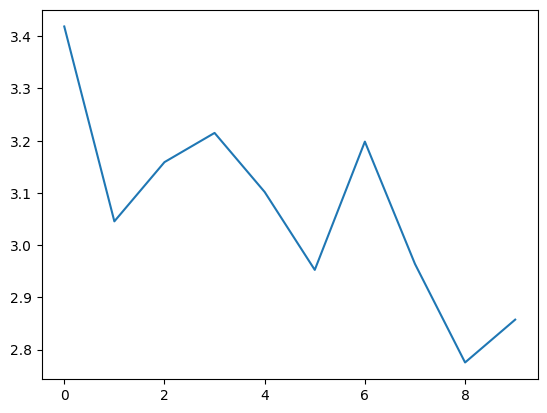

In [79]:
plt.plot(lossi[:10])

# plot loss

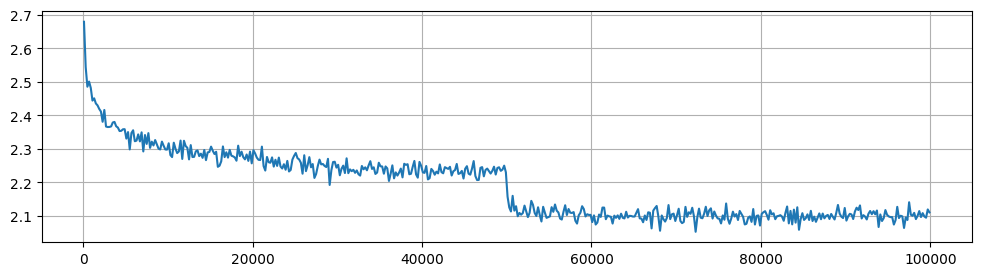

In [81]:
group_size = 200
plt.figure(figsize=(12,3))
plt.plot(
    torch.arange(len(lossi)).view(-1, group_size).float().mean(1),
    torch.tensor(lossi).view(-1, group_size).mean(1)
)
plt.grid()
plt.show()

## compute loss on train/dev/test

In [57]:
@torch.no_grad()
def eval_dataset(X, Y):
    emb = C[X] # (32, 3, 2)
    h = (emb.view(emb.shape[0], -1) @ w1 + b1).tanh() # (32, 100)
    logits = h @ w2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y)
    print(loss.item())

In [58]:
eval_dataset(Xtr, Ytr)
eval_dataset(Xdv, Ydv)
# eval_dataset(Xte, Yte)

2.097853183746338
2.146559953689575


# generate names

In [34]:
g = torch.Generator().manual_seed(2147483647 + 10)

In [35]:
for _ in range(10):
    out = []
    context = [0] * BLOCK_SIZE
    while True:
        emb = C[torch.tensor([context])]
        h = (emb.view(1, -1) @ w1 + b1).tanh()
        logits = h @ w2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

cartavela.
jhleigh.
mrix.
tatyannah.
sae.
mahnen.
amerric.
kaquil.
ramara.
chaiha.


# Q1: Neural Smoothing?